In [1]:
import torch
import json
import numpy as np
from PIL import Image
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Loading Images

In [2]:
config = json.load(open("../config/config_target_position_.json"))
image_src = np.array(Image.open("../images/new_source_img_.jpg").convert("RGB"))/255.0
target_img = np.array(Image.open("../images/new_target_one_.jpg").convert("RGB"))/255.0
mask_img = np.array(Image.open("../images/new_mask_img_.jpg").convert("L"))/255.0

In [3]:
x_start, y_start = config.values()
ss = image_src.shape; # source image size
ts = target_img.shape; # target image size
h, w = mask_img.shape
x_temp = [x_start, x_start+w]
y_temp = [y_start, y_start+h]

In [4]:
def plots_all(*images):
    fig, axs = plt.subplots(1, len(images),
                           figsize=(14, 10),
                           tight_layout=True)
    for ax, image in zip(axs, images):
        if image.shape[0] == 1:
            image = image.squeeze()
        ax.imshow(image, cmap="gray")
        # ax.set_axis_off()
    plt.show()

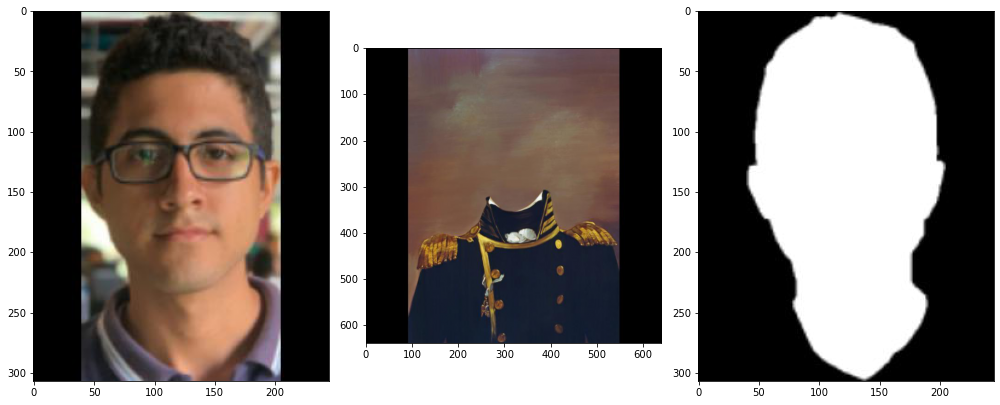

In [5]:
plots_all(image_src, target_img, mask_img)

# Make canvas mask

In [6]:
def make_canvas_mask(x_start, y_start, target_img, mask):
    h, w = mask.shape
    x_temp = [x_start, x_start+w]
    y_temp = [y_start, y_start+h]
    canvas_mask = np.zeros((target_img.shape[0], target_img.shape[1]))
    canvas_mask[y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]] = mask
    return canvas_mask

In [7]:
canvas_mask = make_canvas_mask(x_start, y_start, target_img, mask_img)

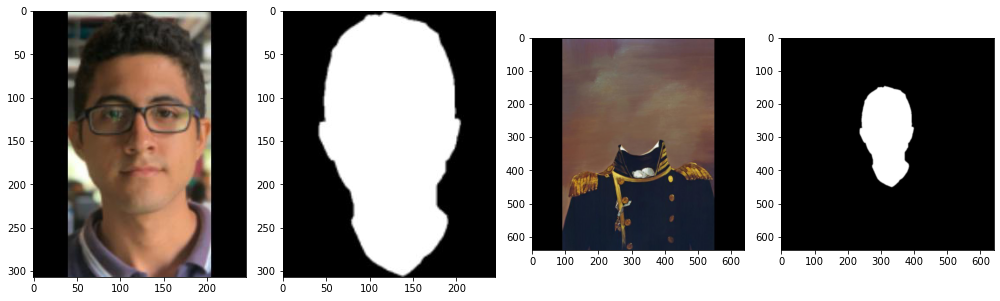

In [8]:
plots_all(image_src, mask_img, target_img, canvas_mask)

# Get ground truth gradients

In [9]:
from kornia import filters

gpu_id = torch.device("cuda")


In [10]:
def laplacian_filter_tensor(img_tensor, gpu_id):

    laplacian_filters = filters.Laplacian(kernel_size=3, normalized=False)(img_tensor.cpu())

#     laplacian_filter = np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]])
#     laplacian_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
#     laplacian_conv.weight = nn.Parameter(torch.from_numpy(laplacian_filter).float().unsqueeze(0).unsqueeze(0).to(gpu_id))
    
#     for param in laplacian_conv.parameters():
#         param.requires_grad = False
    
#     red_img_tensor = img_tensor[:,0,:,:].unsqueeze(1)
#     green_img_tensor = img_tensor[:,1,:,:].unsqueeze(1)
#     blue_img_tensor = img_tensor[:,2,:,:].unsqueeze(1)
    
#     red_gradient_tensor = laplacian_conv(red_img_tensor).squeeze(1) 
#     green_gradient_tensor = laplacian_conv(green_img_tensor).squeeze(1) 
#     blue_gradient_tensor = laplacian_conv(blue_img_tensor).squeeze(1)

    red_gradient_tensor = laplacian_filters[:,0,:,:].squeeze(1) 
    green_gradient_tensor = laplacian_filters[:,1,:,:].squeeze(1) 
    blue_gradient_tensor = laplacian_filters[:,2,:,:].squeeze(1)
    
    return red_gradient_tensor.to(gpu_id), green_gradient_tensor.to(gpu_id), blue_gradient_tensor.to(gpu_id)

In [11]:
def numpy2tensor(np_array, gpu_id):
    if len(np_array.shape) == 2:
        tensor = torch.from_numpy(np_array).unsqueeze(0).float().to(gpu_id)
    else:
        tensor = torch.from_numpy(np_array).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(gpu_id)
    return tensor

In [12]:
def compute_gt_gradient(x_start, y_start, source_img, target_img, mask, gpu_id):
    h, w = mask.shape
    x_temp = [x_start, x_start+w]
    y_temp = [y_start, y_start+h]
    
    # compute source image gradient
    source_img_tensor = torch.from_numpy(source_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(gpu_id)
    red_source_gradient_tensor, green_source_gradient_tensor, blue_source_gradient_tenosr = laplacian_filter_tensor(source_img_tensor, gpu_id)    
    red_source_gradient = red_source_gradient_tensor.cpu().data.numpy()[0]
    green_source_gradient = green_source_gradient_tensor.cpu().data.numpy()[0]
    blue_source_gradient = blue_source_gradient_tenosr.cpu().data.numpy()[0]
    
    # compute target image gradient
    target_img_tensor = torch.from_numpy(target_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(gpu_id)
    red_target_gradient_tensor, green_target_gradient_tensor, blue_target_gradient_tenosr = laplacian_filter_tensor(target_img_tensor, gpu_id)    
    red_target_gradient = red_target_gradient_tensor.cpu().data.numpy()[0]
    green_target_gradient = green_target_gradient_tensor.cpu().data.numpy()[0]
    blue_target_gradient = blue_target_gradient_tenosr.cpu().data.numpy()[0]    
    
    # mask and canvas mask
    canvas_mask = np.zeros((target_img.shape[0], target_img.shape[1]))
    canvas_mask[y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]] = mask
    
    # foreground gradient
    red_source_gradient = red_source_gradient * mask
    green_source_gradient = green_source_gradient * mask
    blue_source_gradient = blue_source_gradient * mask
    red_foreground_gradient = np.zeros((canvas_mask.shape))
    red_foreground_gradient[y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]] = red_source_gradient
    green_foreground_gradient = np.zeros((canvas_mask.shape))
    green_foreground_gradient[y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]] = green_source_gradient
    blue_foreground_gradient = np.zeros((canvas_mask.shape))
    blue_foreground_gradient[y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]] = blue_source_gradient
    
    # background gradient
    red_background_gradient = red_target_gradient * (canvas_mask - 1) * (-1)
    green_background_gradient = green_target_gradient * (canvas_mask - 1) * (-1)
    blue_background_gradient = blue_target_gradient * (canvas_mask - 1) * (-1)
    
    # add up foreground and background gradient
    alpha = 0.5
    gt_red_gradient = red_foreground_gradient * (1 - alpha) + red_background_gradient * (alpha)
    gt_green_gradient = green_foreground_gradient * (1 - alpha) + green_background_gradient * (alpha)
    gt_blue_gradient = blue_foreground_gradient * (1 - alpha) + blue_background_gradient * (alpha)
    
    gt_red_gradient = numpy2tensor(gt_red_gradient, gpu_id)
    gt_green_gradient = numpy2tensor(gt_green_gradient, gpu_id)  
    gt_blue_gradient = numpy2tensor(gt_blue_gradient, gpu_id)
    
    gt_gradient = [gt_red_gradient, gt_green_gradient, gt_blue_gradient]
    return gt_gradient

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


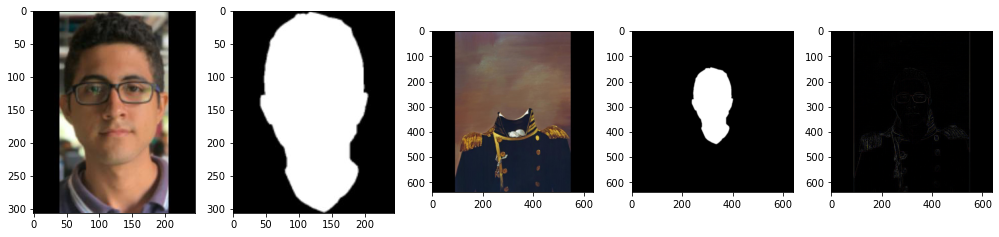

In [13]:
gt_gradient = compute_gt_gradient(x_start, y_start, image_src, target_img, mask_img, gpu_id)

plots_all(image_src, mask_img, target_img, canvas_mask, np.transpose(torch.stack(gt_gradient).squeeze().cpu(), (1, 2, 0)))

In [14]:
canvas_mask = numpy2tensor(canvas_mask, gpu_id)
source_img = image_src.copy()
canvas_mask = canvas_mask.squeeze(0).repeat(3,1).view(3,ts[0],ts[1]).unsqueeze(0)
# Convert Numpy Images Into Tensors
source_img = torch.from_numpy(source_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(gpu_id)
target_img = torch.from_numpy(target_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(gpu_id)
input_img = torch.randn(target_img.shape).to(gpu_id)

In [15]:
# t = T.ToPILImage()

# t(target_img.squeeze().cpu()).save("target.jpg")

# t(canvas_mask.squeeze().cpu()).save("mask.jpg")

# new_src_img = torch.zeros_like(target_img)
# new_src_img[:,:,y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]] = source_img
# t(new_src_img.squeeze().cpu()).save("src.jpg")

In [16]:
# input_img[:,:,y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]] = source_img

In [17]:
mask_img = numpy2tensor(mask_img, gpu_id)
mask_img = mask_img.squeeze(0).repeat(3,1).view(3,ss[0],ss[1]).unsqueeze(0)

# Test Image blending

In [18]:
from lbfgs import LBFGS
from utils import MeanShift, Vgg16, gram_matrix

In [19]:
# Default weights for loss functions in the first pass
grad_weight = 1e4; style_weight = 1e4; content_weight = 1; tv_weight = 1e-6
# Define LBFGS optimizer
def get_input_optimizer(input_img):
    optimizer = LBFGS([input_img.requires_grad_()], lr=1.5)
    return optimizer
optimizer = get_input_optimizer(input_img)

# Define Loss Functions
mse = torch.nn.MSELoss()

# Import VGG network for computing style and content loss
mean_shift = MeanShift(gpu_id)
vgg = Vgg16().to(gpu_id)

In [ ]:
run = [0]
while run[0] <= 1000:
    
    def closure():
        # Composite Foreground and Background to Make Blended Image
        blend_img = torch.zeros(target_img.shape).to(gpu_id)
        blend_img = input_img*canvas_mask + target_img*(canvas_mask-1)*(-1) 
        
#         print((target_img*(canvas_mask-1)*(-1)).shape)
        
        # Compute Laplacian Gradient of Blended Image
        pred_gradient = laplacian_filter_tensor(blend_img, gpu_id)
        
        sw = run[0]%50 == 0
#         if (sw):
#             plt.imshow(np.transpose(torch.stack(pred_gradient).detach().squeeze().cpu().numpy(), (1, 2, 0)))
#             plt.show()
#             plt.imshow(np.transpose(torch.stack(gt_gradient).detach().squeeze().cpu().numpy(), (1, 2, 0)))
#             plt.show()
        
        # Compute Gradient Loss
        grad_loss = 0
        for c in range(len(pred_gradient)):
            grad_loss += mse(pred_gradient[c], gt_gradient[c])
        grad_loss /= len(pred_gradient)
        grad_loss *= grad_weight
        
        # Compute Style Loss
        target_features_style = vgg(mean_shift(target_img))
        target_gram_style = [gram_matrix(y) for y in target_features_style]
        
        blend_features_style = vgg(mean_shift(input_img))
        blend_gram_style = [gram_matrix(y) for y in blend_features_style]
        
        style_loss = 0
        for layer in range(len(blend_gram_style)):
            style_loss += mse(blend_gram_style[layer], target_gram_style[layer])
        style_loss /= len(blend_gram_style)  
        style_loss *= style_weight           

        
        # Compute Content Loss
        blend_obj = blend_img[:,:,y_temp[0]:y_temp[1], x_temp[0]:x_temp[1]]
        
#         source_object_features = vgg(source_img*mask_img)
#         blend_object_features = vgg(blend_obj*mask_img)
        
        source_object_features = vgg(mean_shift(source_img*mask_img))
        blend_object_features = vgg(mean_shift(blend_obj*mask_img))
        
#         if sw:
#             plt.imshow(np.transpose((source_img*mask_img).detach().cpu().numpy().squeeze(), (1, 2,  0)))
#             plt.show()
#             plt.close()
#             plt.imshow(np.transpose((blend_obj*mask_img).detach().cpu().numpy().squeeze(), (1, 2,  0)))
#             plt.show()
#             plt.close()
            
        content_loss = content_weight * mse(blend_object_features.relu2_2, source_object_features.relu2_2)
        content_loss *= content_weight
        
        # Compute TV Reg Loss
        tv_loss = torch.sum(torch.abs(blend_img[:, :, :, :-1] - blend_img[:, :, :, 1:])) + \
                   torch.sum(torch.abs(blend_img[:, :, :-1, :] - blend_img[:, :, 1:, :]))
        tv_loss *= tv_weight
        
        # Compute Total Loss and Update Image
        loss = grad_loss + style_loss + content_loss + tv_loss 
        
        optimizer.zero_grad()
        loss.backward()
        
        # Print Loss
        if run[0] % 1 == 0:
            print("run {}:".format(run))
            print('grad : {:4f}, style : {:4f}, content: {:4f}, tv: {:4f}'.format(\
                          grad_loss.item(), \
                          style_loss.item(), \
                          content_loss.item(), \
                          tv_loss.item()
                          ))
            print()
        
        run[0] += 1
        return loss
    
    optimizer.step(closure)

run [0]:
grad : 60827.957031, style : 21.671869, content: 10.941090, tv: 0.247845

run [1]:
grad : 60825.500000, style : 21.671783, content: 10.940905, tv: 0.247841

run [2]:
grad : 15447.586914, style : 19.728216, content: 6.598289, tv: 0.128673

run [3]:
grad : 4149.258789, style : 19.052551, content: 5.132051, tv: 0.076707

run [4]:
grad : 1303.235352, style : 18.643623, content: 4.205189, tv: 0.050947

run [5]:
grad : 541.237976, style : 18.440046, content: 3.880964, tv: 0.040437

run [6]:
grad : 311.614868, style : 18.337566, content: 3.612839, tv: 0.035340

run [7]:
grad : 206.719528, style : 18.257998, content: 3.315850, tv: 0.031834

run [8]:
grad : 121.370918, style : 18.082888, content: 2.546069, tv: 0.026565

run [9]:
grad : 110.362862, style : 17.965918, content: 2.131766, tv: 0.024147

run [10]:
grad : 74.640869, style : 17.946682, content: 2.115136, tv: 0.023373

run [11]:
grad : 66.447250, style : 17.891336, content: 1.957733, tv: 0.022561

run [12]:
grad : 59.856712, st

In [ ]:
# clamp the pixels range into 0 ~ 255
# input_img.data.clamp_(0, 255)

# Make the Final Blended Image
blend_img = torch.zeros(target_img.shape).to(gpu_id)
blend_img = input_img*canvas_mask + target_img*(canvas_mask-1)*(-1)
blend_img_np = blend_img.transpose(1,3).transpose(1,2).cpu().data.numpy()[0]
blend_img = blend_img.cpu().data.squeeze()

In [ ]:
image = T.ToPILImage()((blend_img*255.0).to(torch.uint8))
image

In [ ]:
image.save("../results/result_1_.jpg")

# Transfer style

Optimizing...
run [0]:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 style : 0.000602, content: 0.000000



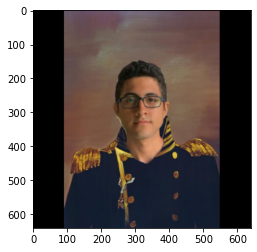

run [1]:
 style : 0.000601, content: 0.000000

run [2]:
 style : 0.000589, content: 0.000000

run [3]:
 style : 0.000515, content: 0.000000

run [4]:
 style : 0.000485, content: 0.000000

run [5]:
 style : 0.000386, content: 0.000000

run [6]:
 style : 0.000327, content: 0.000000

run [7]:
 style : 0.000285, content: 0.000000

run [8]:
 style : 0.000254, content: 0.000000

run [9]:
 style : 0.000208, content: 0.000000

run [10]:
 style : 0.000203, content: 0.000000

run [11]:
 style : 0.000190, content: 0.000000

run [12]:
 style : 0.000180, content: 0.000000

run [13]:
 style : 0.000152, content: 0.000000

run [14]:
 style : 0.000139, content: 0.000000

run [15]:
 style : 0.000130, content: 0.000000

run [16]:
 style : 0.000126, content: 0.000000

run [17]:
 style : 0.000122, content: 0.000000

run [18]:
 style : 0.000113, content: 0.000000

run [19]:
 style : 0.000103, content: 0.000000



In [25]:
###################################
########### Second Pass ###########
###################################

# Default weights for loss functions in the second pass
style_weight = 1e5; content_weight = 1e2; tv_weight = 1e-6
first_pass_img = torch.from_numpy(blend_img_np).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(gpu_id)
# target_img = torch.from_numpy(target_img).unsqueeze(0).transpose(1,3).transpose(2,3).float().to(gpu_id)

# Define LBFGS optimizer
def get_input_optimizer(first_pass_img):
    optimizer = LBFGS([first_pass_img.requires_grad_()])
    return optimizer

optimizer = get_input_optimizer(first_pass_img)

print('Optimizing...')
run = [0]
while run[0] <= 10:
    
    def closure():
        
        # Compute Loss Loss    
        target_features_style = vgg(mean_shift(target_img))
        target_gram_style = [gram_matrix(y) for y in target_features_style]
        blend_features_style = vgg(mean_shift(first_pass_img))
        blend_gram_style = [gram_matrix(y) for y in blend_features_style]
        style_loss = 0
        for layer in range(len(blend_gram_style)):
            style_loss += mse(blend_gram_style[layer], target_gram_style[layer])
        style_loss /= len(blend_gram_style)  
        style_loss *= style_weight        
        
        # Compute Content Loss
        content_features = vgg(mean_shift(first_pass_img))
        content_loss = content_weight * mse(blend_features_style.relu2_2, content_features.relu2_2)
        
        # Compute Total Loss and Update Image
        loss = style_loss + content_loss
        optimizer.zero_grad()
        loss.backward()
        
        # Print Loss
        if run[0] % 1 == 0:
            print("run {}:".format(run))
            print(' style : {:4f}, content: {:4f}'.format(\
                          style_loss.item(), \
                          content_loss.item()
                          ))
            print()
            
        sw = run[0]%50 == 0
        if (sw):
            plt.imshow(np.transpose(first_pass_img.detach().cpu().numpy().squeeze(), (1, 2, 0)))
            plt.show()
        run[0] += 1
        return loss
    
    optimizer.step(closure)

# clamp the pixels range into 0 ~ 255
first_pass_img.data.clamp_(0, 255)

# Make the Final Blended Image
input_img_np = first_pass_img.transpose(1,3).transpose(1,2).cpu().data.numpy()[0]

In [26]:
# Make the Final Blended Image
input_img_np = first_pass_img.transpose(1,3).transpose(1,2).cpu().data.numpy()[0]
first_pass_img = first_pass_img.cpu().data.squeeze()

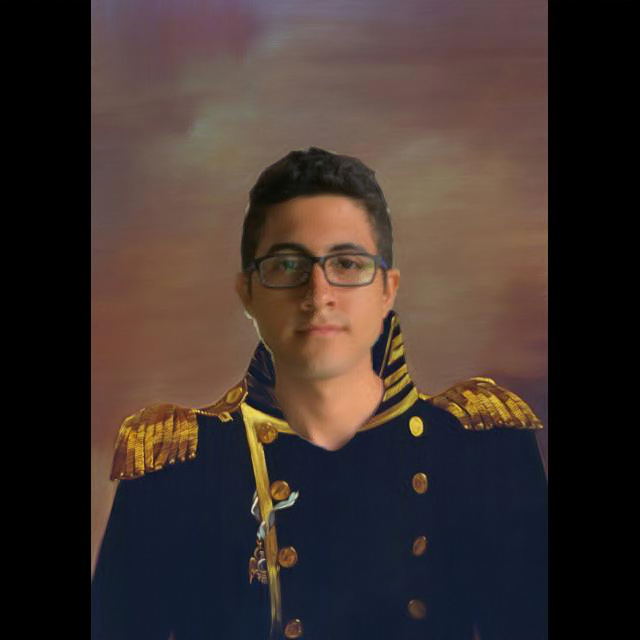

In [27]:
image = T.ToPILImage()((first_pass_img*255.0).to(torch.uint8))
image

In [34]:
image.save("../results/result_2_.jpg")